# Build a stock trader with Q-learning

In [256]:
import time
import datetime
import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt
import data_process as d
import pandas_datareader.data as web # fetch stock data

%matplotlib inline

In [257]:
def initialize_q_mat(all_states, all_actions):
    '''
    Initialize Q-table
    Inputs:
    all_states: a list of all the states values
    all_actions: a dictionary of all possible actions to take
    Output: 
    q_mat: randomly initialized Q-table
    '''
    states_size = len(all_states)
    actions_size = len(all_actions)
    
    q_mat = np.random.rand(states_size, actions_size)/1e9
    q_mat = pd.DataFrame(q_mat, columns=all_actions.keys())
    
    q_mat['states'] = all_states
    q_mat.set_index('states', inplace=True)
    
    return q_mat

def act(state, q_mat, threshold=0.2, actions_size=3):
    '''
    Taking an action based on different strategies: 
    either random pick actions or take the actions 
    with the highest future return
    Inputs:
    state(str)
    q_mat(dataframe): Q-table
    threshold(float): the percentage of picking a random action
    action_size(int): number of possible actions 
    Output:
    action(int)
    '''
    if np.random.uniform(0,1) < threshold: # go random
        action = np.random.randint(low=0, high=actions_size)  
    else:
        action = np.argmax(q_mat.loc[state].values)
    return action

def get_return_since_entry(bought_history, current_adj_close):
    '''
    Calculate the returns of current share holdings.
    Inputs:
    bought_history(list) 
    current_adj_close(float)
    current_day(int)
    Output:
    return_since_entry(float)
    '''
    return_since_entry = 0.
    
    for b in bought_history:
        return_since_entry += (current_adj_close - b)
    return return_since_entry

def visualize_results(actions_history, returns_since_entry):
    '''
    Visualize the trading results with 2 plots
    The upper plot shows the return since entry
    The lower plot shows the action signal
    Inputs:
    actions_history(dict): has everydays' actions and close price
    returns_since_entry(list): contains every day's return since entry
    Output:
    None
    '''
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,12))
    
    ax1.plot(returns_since_entry)
    
    days, prices, actions = [], [], []
    for d, p, a in actions_history:
        days.append(d)
        prices.append(p)
        actions.append(a)

    #ax2.figure(figsize=(20,10))
    ax2.plot(days, prices, label='normalized adj close price')
    hold_d, hold_p, buy_d, buy_p, sell_d, sell_p = [], [], [], [], [], []
    for d, p, a in actions_history:
        if a == 0:
            hold_d.append(d)
            hold_p.append(p)
        if a == 1:
            buy_d.append(d)
            buy_p.append(p)
        if a == 2:
            sell_d.append(d)
            sell_p.append(p)
        # ax2.annotate(all_actions[a], xy=(d,p), xytext=(d-.2, p+0.001), color=color, arrowprops=dict(arrowstyle='->',connectionstyle='arc3'))
    ax2.scatter(hold_d, hold_p, color='blue', label='hold')
    ax2.scatter(buy_d, buy_p, color='green', label='buy')
    ax2.scatter(sell_d, sell_p, color='red', label='sell')
    ax2.legend()
    
def get_invested_capital(actions_history, returns_since_entry):
    '''
    Calculate the max capital being continously invested by the trader
    Input:
    actions_history(dict): has everydays' actions and close price
    returns_since_entry(list): contains every day's return since entry
    Output:
    return_invest_ratio(float)
    '''
    invest = []
    total = 0
    return_invest_ratio = None
    for i in range(len(actions_history)):
        a = actions_history[i][2]
        p = actions_history[i][1]

        try:
            next_a = actions_history[i+1][2]
        except:
            #print('end')
            break
        if a == 1:
            total += p
            #print(total)
            if next_a != 1 or (i==len(actions_history)-2 and next_a==1):
                invest.append(total)
                total = 0
    if invest:
        return_invest_ratio = returns_since_entry[-1]/max(invest)
        print('invested capital {}, return/invest ratio {}'.format(max(invest), return_invest_ratio))
    else:
        print('no buy transactions, invalid training')
    return return_invest_ratio
        
def get_base_return(data):
    '''
    Calculate the benchmark returns of a given stock
    Input:
    data(dataframe): containing normalized close price and state
    Output:
    return/invest ratio(float)
    '''
    start_price, _ = data[0]
    end_price, _ = data[-1]
    return (end_price - start_price)/start_price

In [258]:
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2018, 1, 1)
train_df, test_df = d.get_stock_data('AAPL', start, end, 0.8)


In [259]:
train_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,79.575714,78.860001,79.382858,79.018570,58671200.0,66.964325
2014-01-03,79.099998,77.204285,78.980003,77.282860,98116900.0,65.493416
2014-01-06,78.114288,76.228569,76.778572,77.704285,103152700.0,65.850533
2014-01-07,77.994286,76.845711,77.760002,77.148575,79302300.0,65.379593
2014-01-08,77.937141,76.955711,76.972855,77.637146,64632400.0,65.793633


In [260]:
all_actions = {0:'hold', 1:'buy', 2:'sell'}

train_df = d.create_df(train_df, 3)
price_states_value, bb_states_value, close_sma_ratio_states_value = d.get_states(train_df)
train_df = d.create_state_df(train_df, price_states_value, bb_states_value, close_sma_ratio_states_value)

all_states = d.get_all_states(price_states_value, bb_states_value, close_sma_ratio_states_value)
states_size = len(all_states)

In [261]:
# process test df
test_df = d.create_df(test_df, 3)
test_df = d.create_state_df(test_df, price_states_value, bb_states_value, close_sma_ratio_states_value)

# Data Exploration

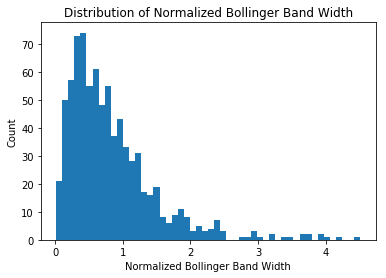

In [262]:
plt.hist(train_df['norm_bb_width'], bins=50);
plt.title('Distribution of Normalized Bollinger Band Width');
plt.ylabel('Count');
plt.xlabel('Normalized Bollinger Band Width');

## train and evaluate helper functions

In [263]:
def train_q_learning(train_data, q, alpha, gamma, episodes):
    '''
    Train a Q-table 
    Inputs:
    train_data(dataframe)
    q(dataframe): initial Q-table
    alpha(float): threshold of which action strategy to take
    gamma(float): discount percentage on the future return
    Output:
    q(dataframe): Updated Q-table
    actions_history(dict): has everydays' actions and close price
    returns_since_entry(list): contains every day's return since entry
    '''
    actions_history = []
    num_shares = 0
    bought_history = []
    returns_since_entry = [0]
    for ii in range(episodes):
        actions_history = []
        num_shares = 0
        bought_history = []
        returns_since_entry = [0]
        days=[0]
        for i, val in enumerate(train_data):
            current_adj_close, state = val
            try:
                next_adj_close, next_state = train_data[i+1]
            except:
                break

            if len(bought_history) > 0:
                returns_since_entry.append(get_return_since_entry(bought_history, current_adj_close)) 
            else:
                returns_since_entry.append(returns_since_entry[-1])

            # decide action
            if alpha > 0.1:
                alpha = alpha/(i+1)
            action = act(state, q, threshold=alpha, actions_size=3)

            # get reward
            if action == 0: # hold
                if num_shares > 0:
                    prev_adj_close, _ = train_data[i-1]
                    future = next_adj_close - current_adj_close 
                    past = current_adj_close - prev_adj_close
                    reward = past
                else:
                    reward = 0

            if action == 1: # buy
                reward = 0
                num_shares += 1
                bought_history.append((current_adj_close))       

            if action == 2: # sell
                if num_shares > 0:
                    bought_price = bought_history[0]
                    reward = (current_adj_close - bought_price)
                    bought_history.pop(0)
                    num_shares -= 1

                else:
                    reward = -100
            actions_history.append((i, current_adj_close, action))
            
            # update q table
            q.loc[state, action] = (1.-alpha)*q.loc[state, action] + alpha*(reward+gamma*(q.loc[next_state].max()))
    print('End of Training!')
    return q, actions_history, returns_since_entry


def eval_q_learning(test_data, q):
    '''
    Evaluate the Q-table
    Inputs:
    test_data(dataframe)
    q(dataframe): trained Q-table
    Output:
    actions_history(dict): has everydays' actions and close price
    returns_since_entry(list): contains every day's return since entry
    '''
    actions_history = []
    num_shares = 0
    returns_since_entry = [0]
    bought_history = []
    
    for i, val in enumerate(test_data):
        current_adj_close, state = val
        try:
            next_adj_close, next_state = test_data[i+1]
        except:
            print('End of data! Done!')
            break   

        if len(bought_history) > 0:
            returns_since_entry.append(get_return_since_entry(bought_history, current_adj_close)) 
        else:
            returns_since_entry.append(returns_since_entry[-1])

        # decide action
        action = act(state, q, threshold=0, actions_size=3)

        if action == 1: # buy
            num_shares += 1
            bought_history.append((current_adj_close))
        if action == 2: # sell
            if num_shares > 0:
                bought_price = bought_history[0]
                bought_history.pop(0)
                num_shares -= 1

        actions_history.append((i, current_adj_close, action))

    return actions_history, returns_since_entry


In [264]:
train_df.head()

,High,Low,Open,Close,Volume,Adj Close,bb_width,close_sma_ratio,norm_adj_close,norm_bb_width,norm_close_sma_ratio,bb_width_state,close_sma_ratio_state,norm_adj_close_state,state
Date,,,,,,,,,,,,,,,
2014-01-06,78.114288,76.228569,76.778572,77.704285,103152700.0,65.850533,0.02321,0.99618,1.000000,1.000000,1.000000,0,1,0,010
2014-01-07,77.994286,76.845711,77.760002,77.148575,79302300.0,65.379593,0.00749,0.99703,0.992848,0.322706,1.000853,0,1,0,010
2014-01-08,77.937141,76.955711,76.972855,77.637146,64632400.0,65.793633,0.00783,1.00181,0.999136,0.337355,1.005652,0,3,0,030
2014-01-09,78.122856,76.478569,78.114288,76.645714,69787200.0,64.953445,0.01285,0.99354,0.986377,0.553641,0.997350,0,1,0,010
2014-01-10,77.257141,75.872856,77.118568,76.134285,76244000.0,64.520035,0.01990,0.99126,0.979795,0.857389,0.995061,0,1,0,010


# Train only with norm_adj_close_state

In [265]:
np.random.seed(12)
q_init = initialize_q_mat(train_df['norm_adj_close_state'].unique(), all_actions)
print('Initializing q')
print(q_init)

Initializing q
                   0             1             2
states                                          
0       1.541628e-10  7.400497e-10  2.633150e-10
1       5.337394e-10  1.457496e-11  9.187470e-10
2       9.007149e-10  3.342143e-11  9.569493e-10
3       1.372093e-10  2.838284e-10  6.060832e-10
4       9.442251e-10  8.527355e-10  2.259234e-12
5       5.212260e-10  5.520376e-10  4.853774e-10
6       7.681342e-10  1.607168e-10  7.645605e-10
7       2.080980e-11  1.352102e-10  1.162730e-10
8       3.098976e-10  6.714526e-10  4.712298e-10
9       8.161683e-10  2.895868e-10  7.331260e-10


In [266]:
train_data = np.array(train_df[['norm_adj_close', 'norm_adj_close_state']])
q, train_actions_history, train_returns_since_entry = train_q_learning(train_data, q_init, alpha=0.8, gamma=0.95, episodes=1)

End of Training!


invested capital 122.94814336101487, return/invest ratio 1.189291269058572
base return/invest ratio 1.068300429107973


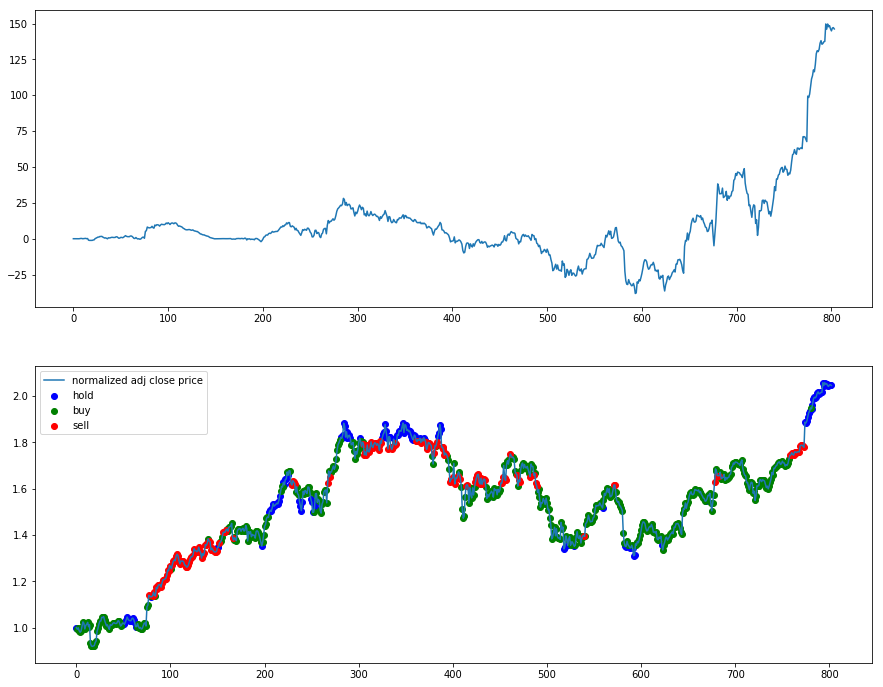

In [267]:
visualize_results(train_actions_history, train_returns_since_entry)
get_invested_capital(train_actions_history, train_returns_since_entry)
print('base return/invest ratio {}'.format(get_base_return(train_data)))

## test dataset evaluation

In [268]:
test_data = np.array(test_df[['norm_adj_close', 'norm_adj_close_state']])
test_actions_history, test_returns_since_entry = eval_q_learning(test_data, q)

End of data! Done!


invested capital 219.5882742089462, return/invest ratio 0.09131260094367928
base return/invest ratio 0.23197006362780614


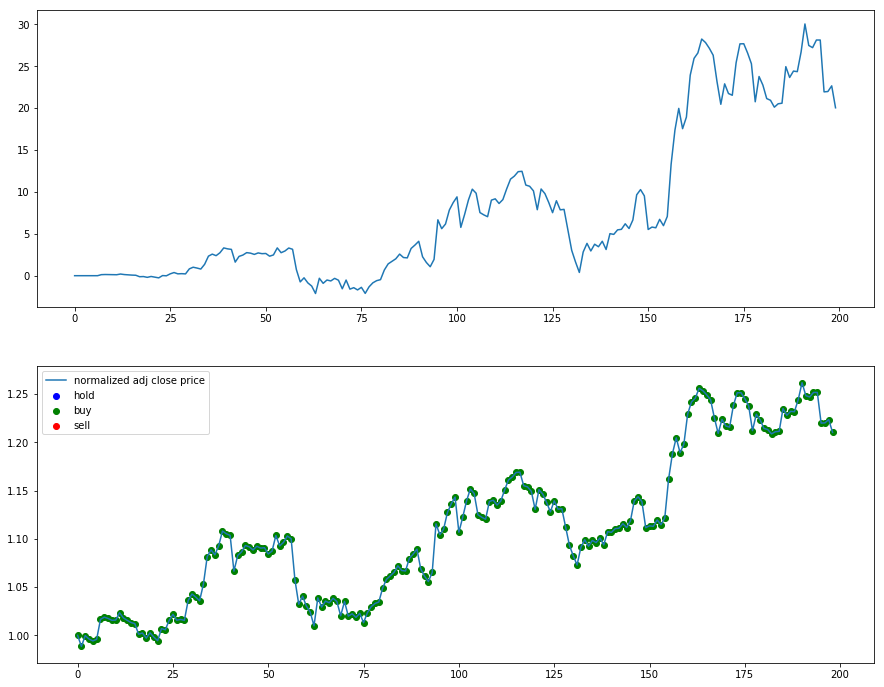

In [269]:
visualize_results(test_actions_history, test_returns_since_entry)
get_invested_capital(test_actions_history, test_returns_since_entry)
print('base return/invest ratio {}'.format(get_base_return(test_data)))

# train with more predictors

In [270]:
np.random.seed(12)
q = initialize_q_mat(all_states, all_actions)/1e9
print('Initializing q')
print(q[:3])

Initializing q
                   0             1             2
states                                          
000     1.541628e-19  7.400497e-19  2.633150e-19
001     5.337394e-19  1.457496e-20  9.187470e-19
002     9.007149e-19  3.342143e-20  9.569493e-19


In [271]:
train_data = np.array(train_df[['norm_adj_close', 'state']])
q, train_actions_history, train_returns_since_entry = train_q_learning(train_data, q, alpha=0.8, gamma=0.95, episodes=1)

End of Training!


invested capital 15.759215011746392, return/invest ratio 1.0460992512574705
base return/invest ratio 1.068300429107973


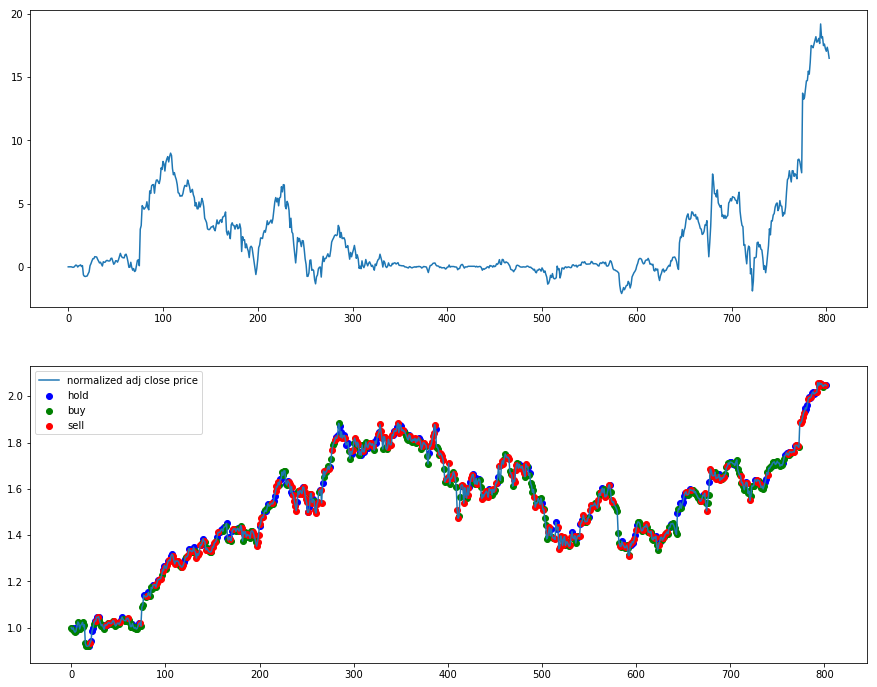

In [272]:
visualize_results(train_actions_history, train_returns_since_entry)
get_invested_capital(train_actions_history, train_returns_since_entry)
print('base return/invest ratio {}'.format(get_base_return(train_data)))

## test evaluation

In [273]:
test_data = np.array(test_df[['norm_adj_close', 'state']])
test_actions_history, test_returns_since_entry = eval_q_learning(test_data, q)

End of data! Done!


invested capital 11.131979474642877, return/invest ratio 0.5500454374434299
base return/invest ratio 0.23197006362780614


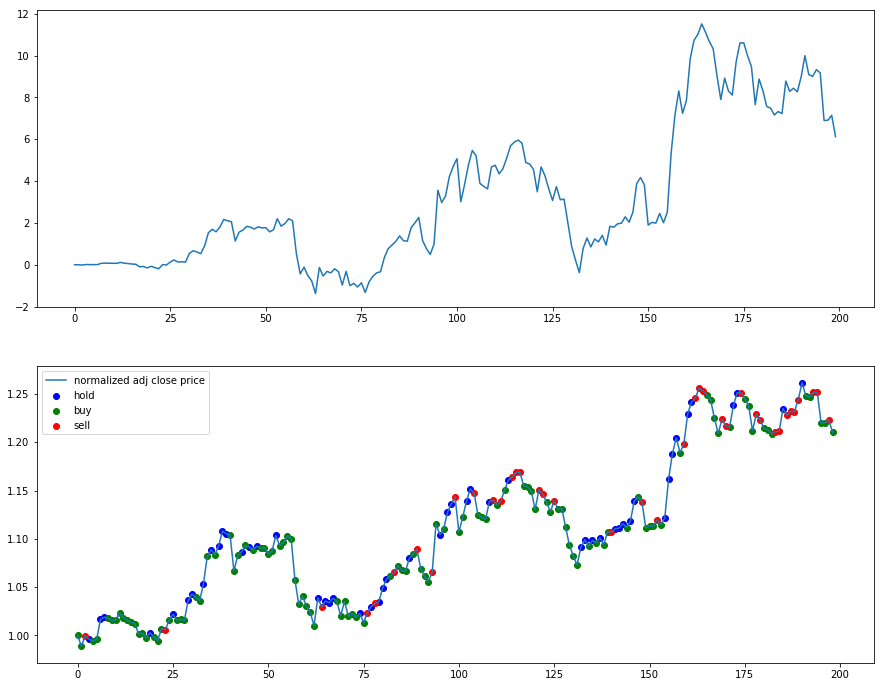

In [274]:
visualize_results(test_actions_history, test_returns_since_entry)
get_invested_capital(test_actions_history, test_returns_since_entry)
# print('invested capital {}, return/invest ratio {}'.format(invested_capital, return_invest_ratio))
print('base return/invest ratio {}'.format(get_base_return(test_data)))

# Train with different number of training episode

In [275]:
train_return_invest_ratios = []
test_return_invest_ratios = []

for e in range(10):
    np.random.seed(12)
    q = initialize_q_mat(all_states, all_actions)/1e9
    
    # train
    train_data = np.array(train_df[['norm_adj_close', 'state']])
    q, train_actions_history, train_returns_since_entry = train_q_learning(train_data, q, alpha=0.8, gamma=0.95, episodes=e)
    
    # print train results
    print('Training Results:')
    train_return_invest_ratio = get_invested_capital(train_actions_history, train_returns_since_entry)
    train_return_invest_ratios.append(train_return_invest_ratio)
    print('base return/invest ratio {}'.format(get_base_return(train_data)))
    
    # test
    print('Test Results:')
    test_actions_history, test_returns_since_entry = eval_q_learning(test_data, q)
    test_return_invest_ratio = get_invested_capital(test_actions_history, test_returns_since_entry)
    test_return_invest_ratios.append(test_return_invest_ratio)
    print('base return/invest ratio {}'.format(get_base_return(test_data)))
    

End of Training!
Training Results:
no buy transactions, invalid training
base return/invest ratio 1.068300429107973
Test Results:
End of data! Done!
invested capital 6.481754088618835, return/invest ratio 0.30892704386808545
base return/invest ratio 0.23197006362780614
End of Training!
Training Results:
invested capital 15.759215011746392, return/invest ratio 1.0460992512574705
base return/invest ratio 1.068300429107973
Test Results:
End of data! Done!
invested capital 11.131979474642877, return/invest ratio 0.5500454374434299
base return/invest ratio 0.23197006362780614
End of Training!
Training Results:
invested capital 16.218516489264886, return/invest ratio 3.9628650008832764
base return/invest ratio 1.068300429107973
Test Results:
End of data! Done!
invested capital 11.131979474642877, return/invest ratio 0.2948184026687335
base return/invest ratio 0.23197006362780614
End of Training!
Training Results:
invested capital 17.77278317482434, return/invest ratio 6.896745733351998
base 

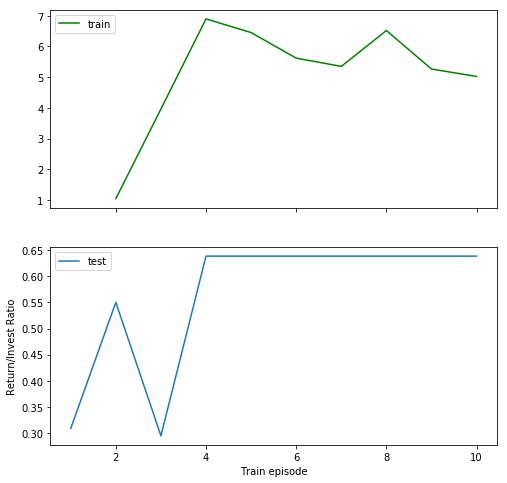

In [276]:
f, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(8,8))
x = [i+1 for i in range(10)]
ax1.plot(x, train_return_invest_ratios, label='train', color='green');
ax2.plot(x, test_return_invest_ratios, label='test');
ax1.legend(loc=2);
ax2.legend(loc=2);
plt.xlabel('Train episode');
plt.ylabel('Return/Invest Ratio');

The best performance is around episode 4, where the train return/invest starts to decrease after that but the test return/invest ratio stays the same.

# Train with different action thresholds

In [277]:
train_return_invest_ratios = []
test_return_invest_ratios = []
alphas = [i*0.05 for i in range(3, 10)]
for a in alphas:
    np.random.seed(12)
    q = initialize_q_mat(all_states, all_actions)/1e9
    
    # train
    train_data = np.array(train_df[['norm_adj_close', 'state']])
    q, train_actions_history, train_returns_since_entry = train_q_learning(train_data, q, alpha=a, gamma=0.95, episodes=4)
    
    # print train results
    print('Training Results:', end='')
    train_return_invest_ratio = get_invested_capital(train_actions_history, train_returns_since_entry)
    train_return_invest_ratios.append(train_return_invest_ratio)
    
    # test
    print('Test Results:', end='')
    test_actions_history, test_returns_since_entry = eval_q_learning(test_data, q)
    test_return_invest_ratio = get_invested_capital(test_actions_history, test_returns_since_entry)
    test_return_invest_ratios.append(test_return_invest_ratio)
    
    

End of Training!
Training Results:invested capital 20.6938132656777, return/invest ratio 5.256913567007622
Test Results:End of data! Done!
invested capital 15.134170372300202, return/invest ratio 0.54898403219273
End of Training!
Training Results:invested capital 17.77278317482434, return/invest ratio 5.594097482021369
Test Results:End of data! Done!
invested capital 15.134170372300202, return/invest ratio 0.517230367992617
End of Training!
Training Results:invested capital 17.757898734596655, return/invest ratio 5.565787832545255
Test Results:End of data! Done!
invested capital 6.194769077495815, return/invest ratio 0.06487863937411234
End of Training!
Training Results:invested capital 17.586650625564744, return/invest ratio 7.5528384921926675
Test Results:End of data! Done!
invested capital 11.131979474642877, return/invest ratio 0.5610674213235827
End of Training!
Training Results:invested capital 22.329540255360783, return/invest ratio 5.672142599057707
Test Results:End of data! Do

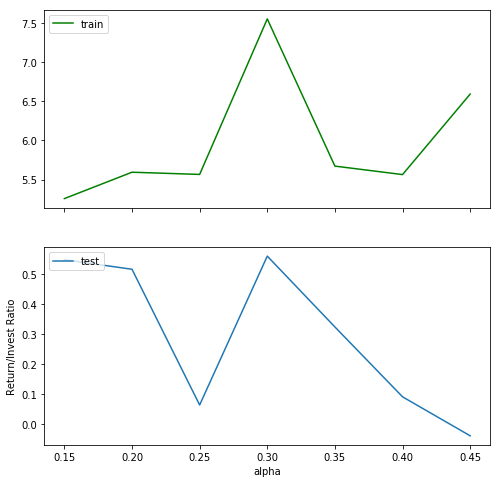

In [278]:
f, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(8,8))
ax1.plot(alphas, train_return_invest_ratios, label='train', color='green');
ax2.plot(alphas, test_return_invest_ratios, label='test');
ax1.legend(loc=2);
ax2.legend(loc=2);
plt.xlabel('alpha');
plt.ylabel('Return/Invest Ratio');

The best return/invest ratio peak at alpha=0.3.

## Visualize test results with best parameters.
alpha=0.3<br>
training_episode=4

In [279]:
# get the best q
start = time.time()
np.random.seed(12)
q = initialize_q_mat(all_states, all_actions)/1e9

# train
train_data = np.array(train_df[['norm_adj_close', 'state']])
q, train_actions_history, train_returns_since_entry = train_q_learning(train_data, q, alpha=0.3, gamma=0.95, episodes=4)
end = time.time()
print('Model trained in {:.3f}s'.format(end-start))

End of Training!
Model trained in 1.793s


End of data! Done!
invested capital 11.131979474642877, return/invest ratio 0.5610674213235827
base return/invest ratio 0.23197006362780614


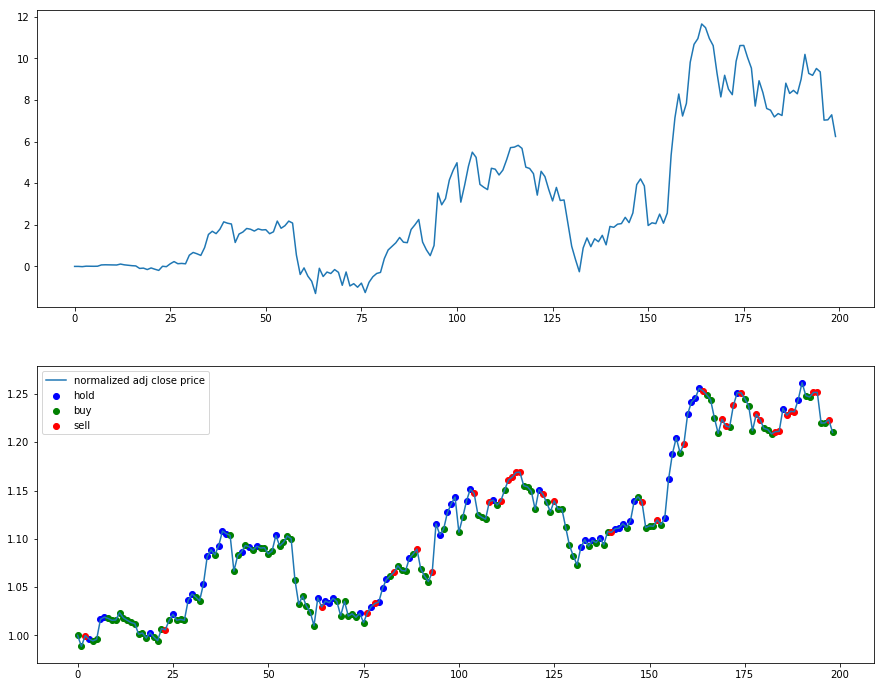

In [280]:
test_actions_history, test_returns_since_entry = eval_q_learning(test_data, q)
visualize_results(test_actions_history, test_returns_since_entry)
get_invested_capital(test_actions_history, test_returns_since_entry)
# print('invested capital {}, return/invest ratio {}'.format(invested_capital, return_invest_ratio))
print('base return/invest ratio {}'.format(get_base_return(test_data)))

# Validation: predictions on other stocks(google)

In [281]:
start = datetime.datetime(2017, 11, 1)
end = datetime.datetime(2017, 12,1)
google_df = d.get_stock_data('GOOG', start, end, train_size=0)
google_df = d.create_df(google_df, 3)
google_df = d.create_state_df(google_df, price_states_value, bb_states_value, close_sma_ratio_states_value)

In [282]:
test_data = np.array(google_df[['norm_adj_close', 'state']])
g_actions_history, g_returns_since_entry = eval_q_learning(test_data, q)

End of data! Done!


In [ ]:
visualize_results(g_actions_history, g_returns_since_entry)
get_invested_capital(g_actions_history, g_returns_since_entry)
print('base return/invest ratio {}'.format(get_base_return(test_data)))

When using Q-learning, it is required to exhaust all possible states before the training starts. Therefore, the trained Q-table will cover the states that only appear in the training dataset. This will lead to failure when we try to use the Q-table to take actions on the test dataset, if any state in test dataset is not seen in the train dataset.

In [255]:
start = datetime.datetime(2017, 11, 1)
end = datetime.datetime(2019, 3,1)
google_df = d.get_stock_data('GOOG', start, end, train_size=0)
google_df = d.create_df(google_df, 3)
google_df = d.create_state_df(google_df, price_states_value, bb_states_value, close_sma_ratio_states_value)

test_data = np.array(google_df[['norm_adj_close', 'state']])
g_actions_history, g_returns_since_entry = eval_q_learning(test_data, q)

visualize_results(g_actions_history, g_returns_since_entry)
get_invested_capital(g_actions_history, g_returns_since_entry)
print('base return/invest ratio {}'.format(get_base_return(test_data)))

KeyError: 'the label [040] is not in the [index]'